In [1]:
from tokenizers import TRIETokenizerFast
import torch
from torch import nn
import numpy as np
import tqdm.notebook as tqdm
import time
import bisect
from typing import *
import gc
from dataclasses import dataclass
from flash_attn import flash_attn_func
from dataloader import DatasetReader
from math import ceil
from functools import partial
from matplotlib import pyplot as plt
import bitsandbytes as bnb

In [2]:
tokenizer = TRIETokenizerFast('llama_vocab_pruned_32k.json')

In [3]:
# Network definition
C_SEQ_LEN = 2048
C_HIDDEN_SIZE = 768
C_NUM_HEADS = 12
C_NUM_LAYERS = 12

C_DEVICE = torch.device('cuda')
C_DTYPE = torch.bfloat16

C_DEBUG = False

In [4]:
if not C_DEBUG:
    train_data = DatasetReader('datasets/tinystories_train.bin')
else:
    train_data = DatasetReader('datasets/debug_data.bin')

In [5]:
print('Train samples:', len(train_data))
print('Train tokens:', len(train_data) * len(next(iter(train_data))['token_ids']))

Train samples: 287582
Train tokens: 588967936


In [6]:
print('Sample 1:', tokenizer.decode(next(iter(train_data))['token_ids']))

Sample 1: <s>Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”
So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. 
And that's how Ben found an amazing vase in the store!</s><s>Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.
One day, Ollie's mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his

In [7]:
global_config = {
    'enable_torch_attn': False,
    'enable_flash_attn': False,
}


@dataclass
class TransformerConfig:
    vocab_size: int = -1,
    num_layers: int = -1,
    num_heads: int = -1,
    hidden_size: int = -1,
    max_seq_len: int = -1,
    root_model: 'ToyTransformer' = None
    device: torch.device = torch.device('cpu')
    dtype: torch.dtype = torch.float32
    enable_rel_pos: bool = False


def expand_attn_mask(custom_attn_mask: torch.Tensor):
    B, T = custom_attn_mask.shape
    mask = custom_attn_mask.unsqueeze(1).repeat((1, T, 1))
    seq_index_mask = (mask == custom_attn_mask[:, torch.arange(T)].view(B, T, 1))
    return seq_index_mask & (torch.tril(mask) > 0)


# naive RoPE implementation following https://arxiv.org/pdf/2104.09864.pdf
def get_rope_cache_slow(seq_len: int, dim: int, theta: int, device: torch.device, dtype: torch.dtype):
    assert dim % 2 == 0
    freqs = theta ** (-2 * torch.arange(0, dim // 2, 1.) / dim)
    freqs = torch.repeat_interleave(freqs, 2)
    v1 = torch.cos(torch.arange(seq_len, dtype=torch.float).view((seq_len, 1)) * freqs)
    v2 = torch.sin(torch.arange(seq_len, dtype=torch.float).view((seq_len, 1)) * freqs)
    v2 = v2 * torch.tensor([1, -1] * (dim // 2))
    indices = torch.tensor([j for i in range(0, dim, 2) for j in (i + 1, i)])
    return v1.to(device, dtype=dtype), v2.to(device, dtype=dtype), indices.to(device)


def apply_rope_slow(x, rope_cache, positions: Optional[torch.Tensor] = None):
    v1, v2, indices = rope_cache
    seq_len, dim = x.shape[1:]
    if positions is None:
        v1 = v1[:seq_len, :]
        v2 = v2[:seq_len, :]
    else:
        v1 = v1[positions, torch.arange(dim)].view((-1, dim))
        v2 = v2[positions, torch.arange(dim)].view((-1, dim))
    applied_x = x * v1 + (x * v2)[:, :, indices]
    return applied_x


# Optimized RoPE implementation adapted from https://github.com/facebookresearch/llama/blob/main/llama/model.py
def get_rope_cache_fast(seq_len: int, dim: int, theta: int, device: torch.device, dtype: torch.dtype):
    freqs = (1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim)))
    t = torch.arange(seq_len, device=freqs.device)
    freqs = torch.outer(t, freqs).float()
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis.to(device)


def apply_rope_fast(x, rope_cache, positions: Optional[torch.Tensor] = None) -> torch.Tensor:
    x_ = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    if positions is None and x.shape[1] < rope_cache.shape[0]:
        freqs_cis = rope_cache[:x.shape[1], :]
    elif positions is not None:
        freqs_cis = rope_cache[positions, :]
    else:
        freqs_cis = rope_cache
    freqs_cis = freqs_cis.view([d if i == 1 or i == x_.ndim - 1 else 1 for i, d in enumerate(x_.shape)])

    applied_x = torch.view_as_real(x_ * freqs_cis).flatten(2)
    return applied_x.type_as(x)


class AttentionHead(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.dtype = config.dtype
        self.q_proj = nn.Linear(config.hidden_size, config.hidden_size // config.num_heads, dtype=config.dtype)
        self.k_proj = nn.Linear(config.hidden_size, config.hidden_size // config.num_heads, dtype=config.dtype)
        self.v_proj = nn.Linear(config.hidden_size, config.hidden_size // config.num_heads, dtype=config.dtype)

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor],
                kv_cache: Optional[List[torch.Tensor]]) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        B, T, C = x.shape

        mask_zero = torch.tensor(0, dtype=self.dtype)
        mask_val = torch.tensor(torch.finfo(self.dtype).min / 2, dtype=self.dtype)
        if kv_cache is None and attn_mask is not None:
            apply_mask = expand_attn_mask(attn_mask)
        elif kv_cache is None and not global_config['enable_torch_attn'] and not global_config['enable_flash_attn']:
            apply_mask = expand_attn_mask(torch.ones(x.shape[:2]))
        elif kv_cache is not None:
            apply_mask = torch.ones((B, T, T), dtype=torch.bool)
        else:
            apply_mask = None

        if not global_config['enable_torch_attn'] and not global_config['enable_flash_attn']:
            apply_mask = torch.where(apply_mask, mask_zero, mask_val)

        use_flash_attn = global_config['enable_flash_attn'] and kv_cache is None and apply_mask is None

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        if self.config.enable_rel_pos:
            positions = torch.tensor([kv_cache[0].shape[1]]).to(q.device) if kv_cache is not None else None
            q = apply_rope_fast(q, self.config.root_model.rope_cache, positions)
            k = apply_rope_fast(k, self.config.root_model.rope_cache, positions)

        if kv_cache is not None:
            k = torch.concat([kv_cache[0], k], dim=1)
            v = torch.concat([kv_cache[1], v], dim=1)

        if use_flash_attn:
            q, k, v, = q.unsqueeze(2), k.unsqueeze(2), v.unsqueeze(2)
            attn_result = flash_attn_func(q, k, v, causal=True)
            q, k, v, attn_result = q.squeeze(2), k.squeeze(2), v.squeeze(2), attn_result.squeeze(2)
        elif global_config['enable_torch_attn']:
            with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_math=True, enable_mem_efficient=True):
                attn_result = nn.functional.scaled_dot_product_attention(q, k, v,
                                                                         attn_mask=apply_mask.to(q.device) if apply_mask is not None else None,
                                                                         is_causal=True if apply_mask is None else False)
        else:
            attn_score = (q @ k.permute(0, 2, 1) / (self.hidden_size ** 0.5)) + apply_mask.to(q.device)
            attn_result = torch.softmax(attn_score, dim=2) @ v

        return attn_result, [k, v]


class MultiHeadAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.config = config
        self.attn_heads = nn.ModuleList([AttentionHead(config) for _ in range(config.num_heads)])
        self.o_proj = nn.Linear(config.hidden_size, config.hidden_size, dtype=config.dtype)

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor],
                kv_cache: Optional[List[torch.Tensor]]) -> Tuple[torch.Tensor, List[List[torch.Tensor]]]:
        head_outputs = [head(x, attn_mask, kv_cache[idx] if kv_cache is not None else None) for idx, head in
                        enumerate(self.attn_heads)]
        return self.o_proj(torch.concat([o[0] for o in head_outputs], dim=2)), [o[1] for o in head_outputs]


class DecoderLayer(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.config = config
        self.mha = MultiHeadAttention(config)
        self.up_proj = nn.Linear(config.hidden_size, config.hidden_size * 4, dtype=config.dtype)
        self.down_proj = nn.Linear(config.hidden_size * 4, config.hidden_size, dtype=config.dtype)
        self.ln_mha = nn.LayerNorm(config.hidden_size, dtype=config.dtype)
        self.ln_ffn = nn.LayerNorm(config.hidden_size, dtype=config.dtype)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor],
                kv_cache: Optional[List[torch.Tensor]]) -> Tuple[torch.Tensor, List[List[torch.Tensor]]]:
        mha_output, new_kv_cache = self.mha(self.ln_mha(x), attn_mask, kv_cache)
        mha_output = x + mha_output
        ffn_output = self.down_proj(self.act(self.up_proj(self.ln_ffn(mha_output))))
        return mha_output + ffn_output, new_kv_cache


class ToyTransformer(nn.Module):
    def __init__(self, vocab_size: int, num_layers: int, num_heads: int, hidden_size: int, max_seq_len: int,
                 device: torch.device = torch.device('cpu'), dtype: torch.dtype = torch.float32,
                 enable_rel_pos: bool = False):
        super().__init__()
        self.config = TransformerConfig(vocab_size, num_layers, num_heads, hidden_size, max_seq_len, self, device,
                                        dtype, enable_rel_pos)

        self.sem_embed = nn.Embedding(vocab_size, hidden_size, dtype=dtype)

        if not self.config.enable_rel_pos:
            self.pos_embed = nn.Embedding(max_seq_len, hidden_size, dtype=dtype)
        else:
            # self.rope_cache = get_rope_cache(max_seq_len, hidden_size // num_heads, 10000, device, dtype)
            self.rope_cache = get_rope_cache_fast(max_seq_len, hidden_size // num_heads, 10000, device, dtype)

        self.decoder_layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(num_layers)])
        self.lm_head = nn.Linear(hidden_size, vocab_size, dtype=dtype)
        self.to(device)

    def forward(self, seq: torch.Tensor,
                position_ids: Optional[torch.Tensor] = None,
                attn_mask: Optional[torch.Tensor] = None,
                kv_cache: Optional[List[torch.Tensor]] = None) -> Tuple[torch.Tensor, List[List[List[torch.Tensor]]]]:

        if self.config.enable_rel_pos:
            hidden = self.sem_embed(seq)
        elif position_ids is not None:
            hidden = self.sem_embed(seq) + self.pos_embed(position_ids)
        else:
            hidden = self.sem_embed(seq) + self.pos_embed(torch.arange(0, seq.shape[1], 1).to(self.device))

        new_kv_cache = []
        for idx, decoder in enumerate(self.decoder_layers):
            hidden, layer_kv_cache = decoder(hidden, attn_mask, kv_cache[idx] if kv_cache is not None else None)
            new_kv_cache.append(layer_kv_cache)

        return self.lm_head(hidden), new_kv_cache

    @property
    def device(self):
        return next(self.parameters()).device

In [8]:
if C_DEBUG:
    model = ToyTransformer(tokenizer.get_vocab_size(), 2, 2, 256, 128, C_DEVICE, C_DTYPE, enable_rel_pos=True)
else:
    model = ToyTransformer(tokenizer.get_vocab_size(), C_NUM_LAYERS, C_NUM_HEADS, C_HIDDEN_SIZE, C_SEQ_LEN, C_DEVICE, C_DTYPE, enable_rel_pos=True)

In [9]:
print('Total parameters:', sum([t.numel() for t in model.parameters()]))
print(model)

Total parameters: 135418880
ToyTransformer(
  (sem_embed): Embedding(32768, 768)
  (decoder_layers): ModuleList(
    (0-11): 12 x DecoderLayer(
      (mha): MultiHeadAttention(
        (attn_heads): ModuleList(
          (0-11): 12 x AttentionHead(
            (q_proj): Linear(in_features=768, out_features=64, bias=True)
            (k_proj): Linear(in_features=768, out_features=64, bias=True)
            (v_proj): Linear(in_features=768, out_features=64, bias=True)
          )
        )
        (o_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (up_proj): Linear(in_features=768, out_features=3072, bias=True)
      (down_proj): Linear(in_features=3072, out_features=768, bias=True)
      (ln_mha): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln_ffn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (act): GELU(approximate='none')
    )
  )
  (lm_head): Linear(in_features=768, out_features=32768, bias=True)
)


In [10]:
gc.collect()
torch.cuda.empty_cache()

In [11]:
def dataset_collate(dataset: DatasetReader, batch_size: int,
                    transform: Optional[Callable[[Dict[str, List[np.ndarray]]], Dict[str, torch.Tensor]]] = None,
                    drop_last: bool = False):
    cur_batch, cur_batch_size = {}, 0
    for entry in iter(dataset):
        for k, v in entry.items():
            cur_batch.setdefault(k, [])
            cur_batch[k].append(v)
        cur_batch_size += 1
        if cur_batch_size == batch_size:
            yield {k: torch.tensor(np.stack(v)) for k, v in cur_batch.items()} if transform is None else transform(cur_batch)
            cur_batch = {}
            cur_batch_size = 0
    if not drop_last and len(cur_batch) > 0:
        yield {k: torch.tensor(np.stack(v)) for k, v in cur_batch.items()} if transform is None else transform(cur_batch)

In [12]:
# type cast for handling int16/uint16 columns
def train_transform(batch: Dict[str, List[np.ndarray]]):
    return {k: torch.tensor(np.stack(v, dtype=np.int32 if v[0].dtype in [np.int16, np.uint16] else v[0].dtype)) for k, v in batch.items()}


def train_model(model: nn.Module, num_epochs: int, batch_size: int, gradient_accumulation_steps: int,
                max_lr: float, min_lr: float, warmup_ratio: float,
                dataset: DatasetReader, gradient_clip: float = 1.0, show_progress=True,
                train_logs: Optional[List] = None):
    if train_logs is None:
        train_logs = []

    total_samples = len(dataset)
    epoch_steps = ceil(total_samples / batch_size)
    assert epoch_steps >= gradient_accumulation_steps, f'per-epoch steps {epoch_steps} is less than gradient accumulation steps {gradient_accumulation_steps}'

    schedule_steps = ceil(total_samples / batch_size / gradient_accumulation_steps)
    total_steps = schedule_steps * num_epochs

    optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                                                    total_steps=total_steps,
                                                    final_div_factor=max_lr / min_lr, pct_start=warmup_ratio)

    bar = tqdm.tqdm(total=total_steps, disable=not show_progress)

    model.train()
    for epoch_num in range(num_epochs):
        optimizer.zero_grad()
        for batch_idx, batch in enumerate(dataset_collate(dataset, batch_size, train_transform)):
            step_start_time = time.time()

            tokens = batch['token_ids'].to(model.device)
            inputs = tokens[:, :-1]
            labels = tokens[:, 1:]

            positions = batch['position_ids'][:, :-1].to(model.device) if 'position_ids' in batch else None
            attn_mask = batch['attn_mask'][:, :-1].to(model.device) if 'attn_mask' in batch else None
            loss_mask = batch['loss_mask'][:, :-1].to(model.device) if 'loss_mask' in batch else None

            logits, kv_state = model.forward(inputs, position_ids=positions, attn_mask=attn_mask)

            probs = torch.softmax(logits, dim=2).view(-1, logits.shape[-1])

            loss = (-torch.log(probs[torch.arange(probs.shape[0]), labels.reshape(-1)]))
            if loss_mask is not None:
                loss = (loss * loss_mask.reshape(-1)).mean() / gradient_accumulation_steps
            else:
                loss = loss.mean() / gradient_accumulation_steps
            
            # brutally clear nan, give up the whole batch
            if torch.isnan(loss):
                print(f'encountered nan loss at epoch {epoch_num+1}, batch {batch_idx}')
                # optimizer.zero_grad()
            else:
                loss.backward()

            if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == epoch_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                optimizer.step()
                optimizer.zero_grad()

                step_time_cost = time.time() - step_start_time
                throughput = round(probs.shape[0] / step_time_cost / 1000, 2)

                step_stat = {'Loss': f'{loss.item() * gradient_accumulation_steps:.3f}',
                             'LR': f'{scheduler.get_last_lr()[0]:.2e}',
                             'Throughput': f'{throughput} kt/s'}

                if show_progress:
                    bar.set_description(f'Epoch {epoch_num + 1}')
                    bar.set_postfix(step_stat)
                else:
                    print(', '.join(f'{s[0]}:{s[1]}' for s in step_stat.items()))

                scheduler.step()
                bar.update(1)
                train_logs.append((epoch_num, batch_idx, step_stat))

    bar.close()

    return train_logs

In [13]:
global_config['enable_flash_attn'] = True
global_config['enable_torch_attn'] = False
last_train_logs = []
if C_DEBUG:
    train_model(model, num_epochs=100, batch_size=2, gradient_accumulation_steps=4, max_lr=1e-3, min_lr=1e-4,
                warmup_ratio=0.1,
                dataset=train_data, train_logs=last_train_logs,
                show_progress=True)
else:
    train_model(model, num_epochs=1, batch_size=12, gradient_accumulation_steps=8, max_lr=6e-4, min_lr=6e-5,
                warmup_ratio=0.1,
                dataset=train_data,
                gradient_clip=0.5, train_logs=last_train_logs,
                show_progress=True)

  0%|          | 0/2996 [00:00<?, ?it/s]

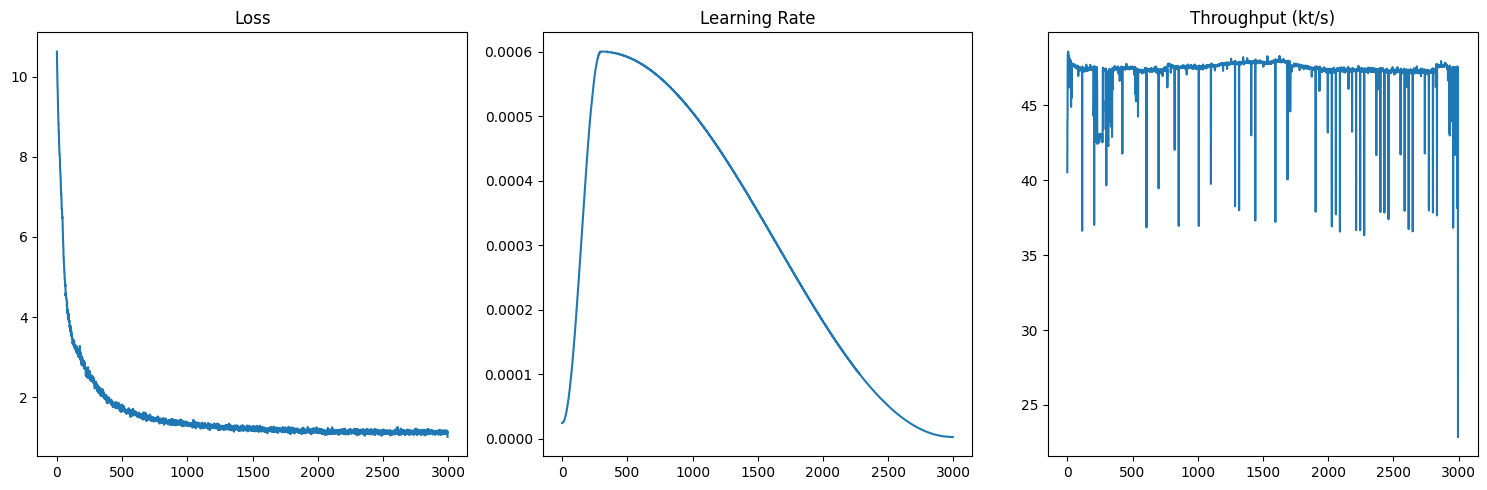

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot([float(l[2]['Loss']) for l in last_train_logs])
axes[1].plot([float(l[2]['LR']) for l in last_train_logs])
axes[2].plot([float(l[2]['Throughput'][:-5]) for l in last_train_logs])
axes[0].set_title('Loss')
axes[1].set_title('Learning Rate')
axes[2].set_title('Throughput (kt/s)')

for ax in axes:
    ax.autoscale()

plt.tight_layout()
plt.show()

In [15]:
run_name = 'checkpoints/train-231022-tinystories'
torch.save(model.state_dict(), f'{run_name}.pt')
torch.save(last_train_logs, f'{run_name}-logs.pt')

In [16]:
def generate(model, tokenizer, prompt, temperature, top_p, rep_penalty,
             max_new_tokens=20, total_tokens=None,
             end_tokens=None,
             enable_kv_cache=True):
    model.eval()

    feed_tokens = tokenizer.encode(prompt)
    all_tokens = feed_tokens.copy()
    if total_tokens is not None:
        max_new_tokens = max(0, total_tokens - len(feed_tokens))

    with torch.no_grad():
        kv_cache = None
        for _ in range(max_new_tokens):
            position_ids = None if kv_cache is None else torch.tensor([[len(all_tokens) - 1]]).to(model.device)
            logits, kv_cache = model.forward(
                torch.tensor([feed_tokens if enable_kv_cache else all_tokens]).to(model.device),
                position_ids=position_ids,
                kv_cache=kv_cache)
            logits = logits[0][-1].cpu()
            if not enable_kv_cache:
                kv_cache = None

            # apply repetition penalty
            logits_rep = torch.gather(logits, 0, torch.tensor(all_tokens))
            logits_rep = torch.where(logits_rep < 0, logits_rep * rep_penalty, logits_rep / rep_penalty)
            logits.scatter_(0, torch.tensor(all_tokens), logits_rep)

            # apply temperature
            logits /= max(temperature, 1e-6)

            probs = torch.softmax(logits, dim=0)

            # apply top-p
            ordered_probs, ordered_indices = torch.sort(probs, descending=True)
            cum_probs = torch.cumsum(ordered_probs, dim=0).tolist()
            top_p_index = bisect.bisect_right(cum_probs, top_p) + 1
            ordered_probs, ordered_indices = ordered_probs[:top_p_index], ordered_indices[:top_p_index]
            sampled_index = ordered_indices[torch.multinomial(ordered_probs, num_samples=1).item()].item()

            all_tokens.append(sampled_index)
            feed_tokens = [sampled_index]

            if end_tokens is not None and sampled_index in end_tokens:
                break

    return tokenizer.decode(all_tokens)

In [17]:
print(repr(tokenizer.decode(next(iter(train_data))['token_ids'].tolist())))

'<s>Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  \nHe said, “Wow, that is a really amazing vase! Can I buy it?” \nThe shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”\nSo Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn\'t believe how lucky Ben was. \nAnd that\'s how Ben found an amazing vase in the store!</s><s>Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.\nOne day, Ollie\'s mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his 

In [20]:
a = time.time()
global_config['enable_flash_attn'] = False
global_config['enable_torch_attn'] = False
result = generate(model, tokenizer, '<s>',
                  temperature=1.0, top_p=0.5, rep_penalty=1.1,
                  total_tokens=128,
                  end_tokens=tokenizer.encode('</s>'),
                  enable_kv_cache=True)
print(repr(result))
print(f'{time.time() - a:.3f} sec(s)')

'<s>Once upon a time, there was a girl named Lucy. She was very adventurous.\nOne day, she was walking through the night. The sunset. "I have been playing in the park, but it was so much more than she was still! The sunny things.\nBut today. Everywhere. Whenever her mommy and this time.\nThe moral of the gardener, she could go to make sure she wanted to get her birthday. She was an hour.</s>'
2.304 sec(s)
